# Productivity During the Two-week Retention Period



In [1]:
library(tidyverse)
library(broom)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

This is rstanarm version 2.21.1

- See https:/

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [ ]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-a-link-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add a Link on each of the wikis
## Note that we turn wiki_db into a factor, otherwise wiki_db in the edit dataset
## becomes a character after joining the two.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'bnwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'cswiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'viwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'fawiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'frwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'huwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'plwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'rowiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'ruwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 130179

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

In [9]:
user_edit_data <- user_edit_data %>%
    inner_join(exp_start_timestamps, by = 'wiki_db') %>%
    mutate(
        # Time as a measurement since deployment
        exp_days = difftime(user_registration_timestamp, exp_start_timestamp, units = 'days'),
        ln_exp_days = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days))),
        ln_exp_weeks = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days)/7))
    )

In [10]:
nrow(user_edit_data)

[1] 130179

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [11]:
user_edit_data <- user_edit_data %>%
    mutate(Group = factor(ifelse(
        hp_enabled == 0, 'Control',
        ifelse(hp_variant == 'control', 'Unstructured', 'Add-a-link')),
                          c('Control', 'Unstructured', 'Add-a-link')))

Our productivity model will fit on the number of constructive article edits in the retention period, so we need a variable for that.

In [12]:
user_edit_data <- user_edit_data %>%
    mutate(num_const_article_edits_2w = num_article_edits_2w - num_article_reverts_2w)

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [13]:
user_edit_data %>%
    group_by(wiki_db, Group) %>%
    summarize(n = n())

`summarise()` regrouping output by 'wiki_db' (override with `.groups` argument)



wiki_db,Group,n
<fct>,<fct>,<int>
arwiki,Control,7698
arwiki,Unstructured,13426
arwiki,Add-a-link,13213
bnwiki,Control,1583
bnwiki,Unstructured,2664
bnwiki,Add-a-link,2679
cswiki,Control,787
cswiki,Unstructured,1419
cswiki,Add-a-link,1447


## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [14]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [15]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Productivity

We'll make box plots of editing based on group, and we'll focus on constructive article edits because that's where we see the strongest effects. This plot uses the `log10(1 + x)` transformation so we get to see all users who didn't make any edits.

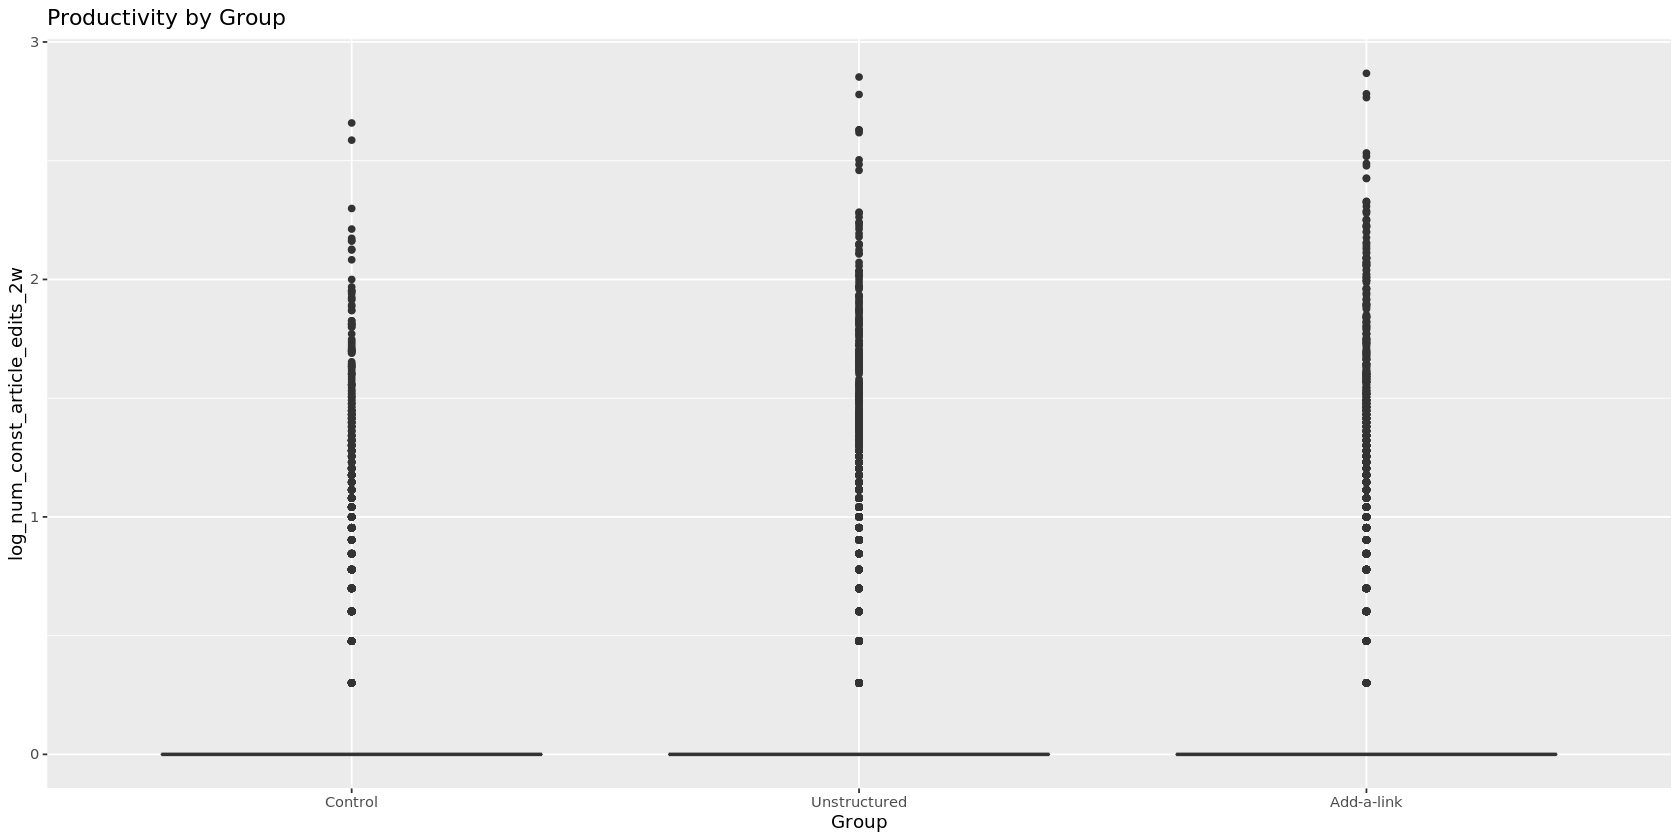

In [18]:
user_edit_data %>%
    mutate(log_num_const_article_edits_2w = log10(1 + num_const_article_edits_2w)) %>%
    ggplot(aes(x = Group, y = log_num_const_article_edits_2w)) +
        labs(title = 'Productivity by Group', yaxis_title = 'Number of constructive edits (log 10 scale)') +
        geom_boxplot()

It's hard to tell if there are any meaningful differences between the groups. Let's summarize and see what we find:

In [20]:
user_edit_data %>%
    group_by(platform, Group) %>%
    summarise(min_edits = min(num_const_article_edits_2w),
              perc_5_edits = quantile(num_const_article_edits_2w, probs = c(0.05)),
              perc_10_edits = quantile(num_const_article_edits_2w, probs = c(0.1)),
              perc_25_edits = quantile(num_const_article_edits_2w, probs = c(0.25)),
              median_edits = median(num_const_article_edits_2w),
              mean_edits = mean(num_const_article_edits_2w),
              perc_75_edits = quantile(num_const_article_edits_2w, probs = c(0.75)),
              perc_90_edits = quantile(num_const_article_edits_2w, probs = c(0.9)),
              perc_95_edits = quantile(num_const_article_edits_2w, probs = c(0.95)),
              perc_99_edits = quantile(num_const_article_edits_2w, probs = c(0.99)),
              max_edits = max(num_const_article_edits_2w),
             .groups = 'keep'
             )

platform,Group,min_edits,perc_5_edits,perc_10_edits,perc_25_edits,median_edits,mean_edits,perc_75_edits,perc_90_edits,perc_95_edits,perc_99_edits,max_edits
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
desktop,Control,0,0,0,0,0,0.536,0,0,1,11,455
desktop,Unstructured,0,0,0,0,0,0.573,0,0,1,11,711
desktop,Add-a-link,0,0,0,0,0,0.736,0,0,1,16,604
mobile,Control,0,0,0,0,0,0.304,0,0,0,6,385
mobile,Unstructured,0,0,0,0,0,0.356,0,0,0,6,600
mobile,Add-a-link,0,0,0,0,0,0.432,0,0,0,7,737


## Priors

In [13]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

# Constructive Article Productivity

When analysing retention, we found that it mainly followed the amount of activity the user did during the activation period. Said amount of activity is affected by `platform` and `Group`, so controlling for them in this case indicates whether there are additional effects associated with those variables. We therefore start with a simple model that does not contain any wiki-level variation and consider a competing model with that later.

In [ ]:
## FIXME: fit this model again because the original one didn't have `platform`
## as a population-level predictor for zero-inflation. It actually didn't
## have it as a group-level predictor either because of a parentheses problem.
constr.article.edits.2w.zinb.1 <- brm(
  bf(num_const_article_edits_2w ~ platform + Group + log_num_const_article_edits_24hrs +
     (1 | wiki_db),
     zi ~ platform + (1 + platform | wiki_db)),
    data = user_edit_data,
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 800,
    control = list(adapt_delta = 0.999,
                 max_treedepth = 15)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.2w.zinb.1,
     file='../models/constr.article.edits.2w.zinb.1.Robj')

In [18]:
summary(constr.article.edits.2w.zinb.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_const_article_edits_2w ~ platform + Group + log_num_const_article_edits_24hrs + (1 | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: user_edit_data (Number of observations: 130179) 
  Draws: 4 chains, each with iter = 800; warmup = 400; thin = 1;
         total post-warmup draws = 1600

Group-Level Effects: 
~wiki_db (Number of levels: 10) 
                                    Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                           0.35      0.11     0.19     0.62 1.00
sd(zi_Intercept)                        2.54      0.83     1.34     4.47 1.00
sd(zi_platformmobile)                   1.89      0.72     0.82     3.53 1.01
cor(zi_Intercept,zi_platformmobile)    -0.85      0.17    -1.00    -0.35 1.00
                                    Bulk_ESS Tail_ESS
sd(Intercept)                            701      866
sd(zi_Intercept)                        

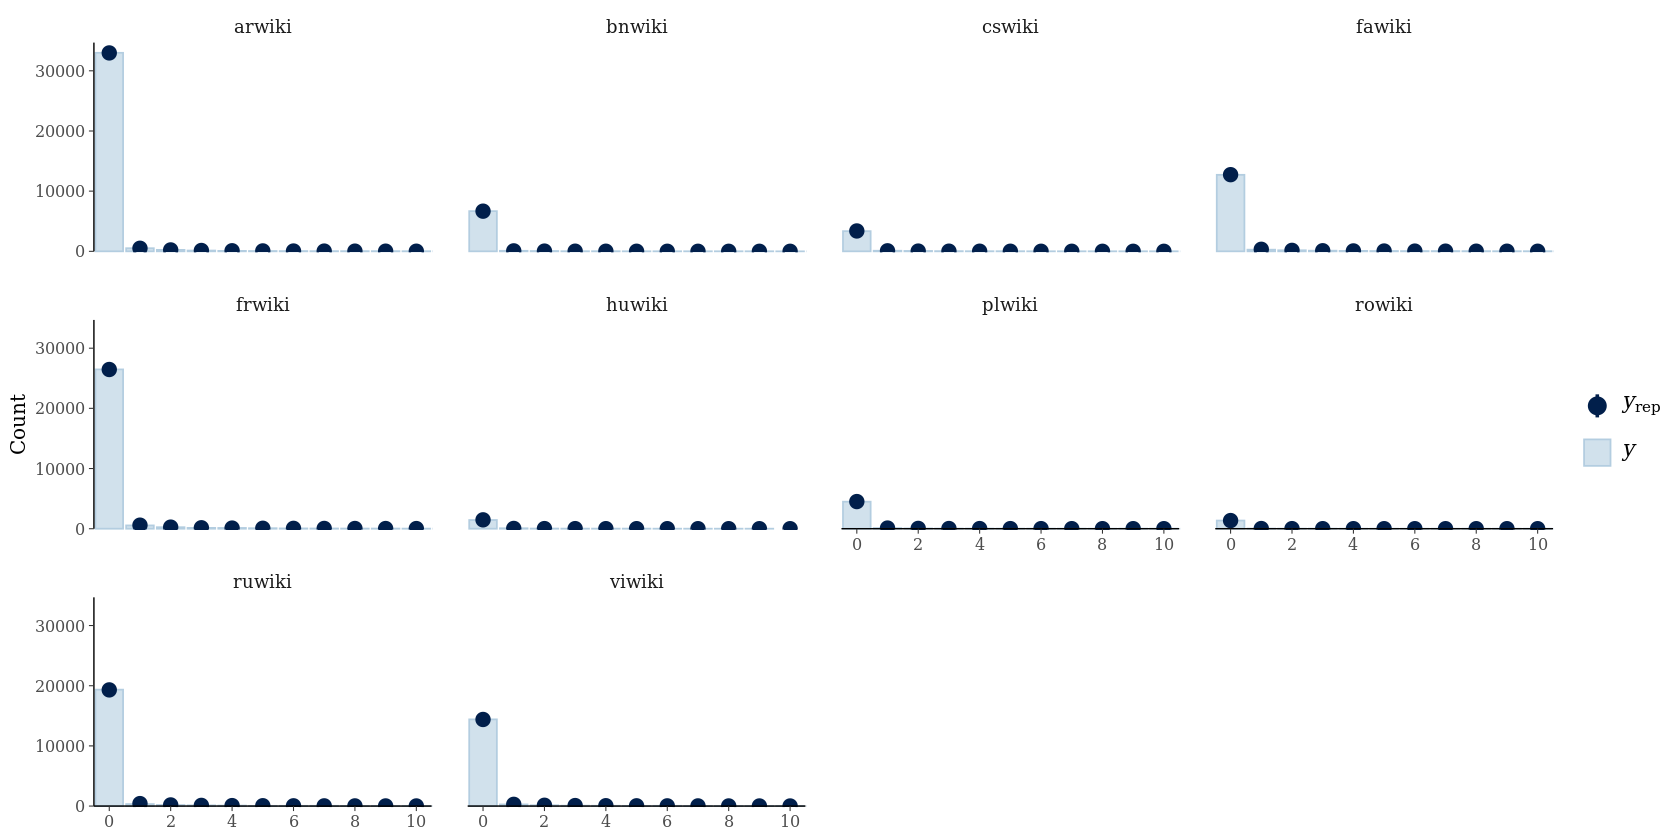

In [19]:
pp_check(constr.article.edits.2w.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10));

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

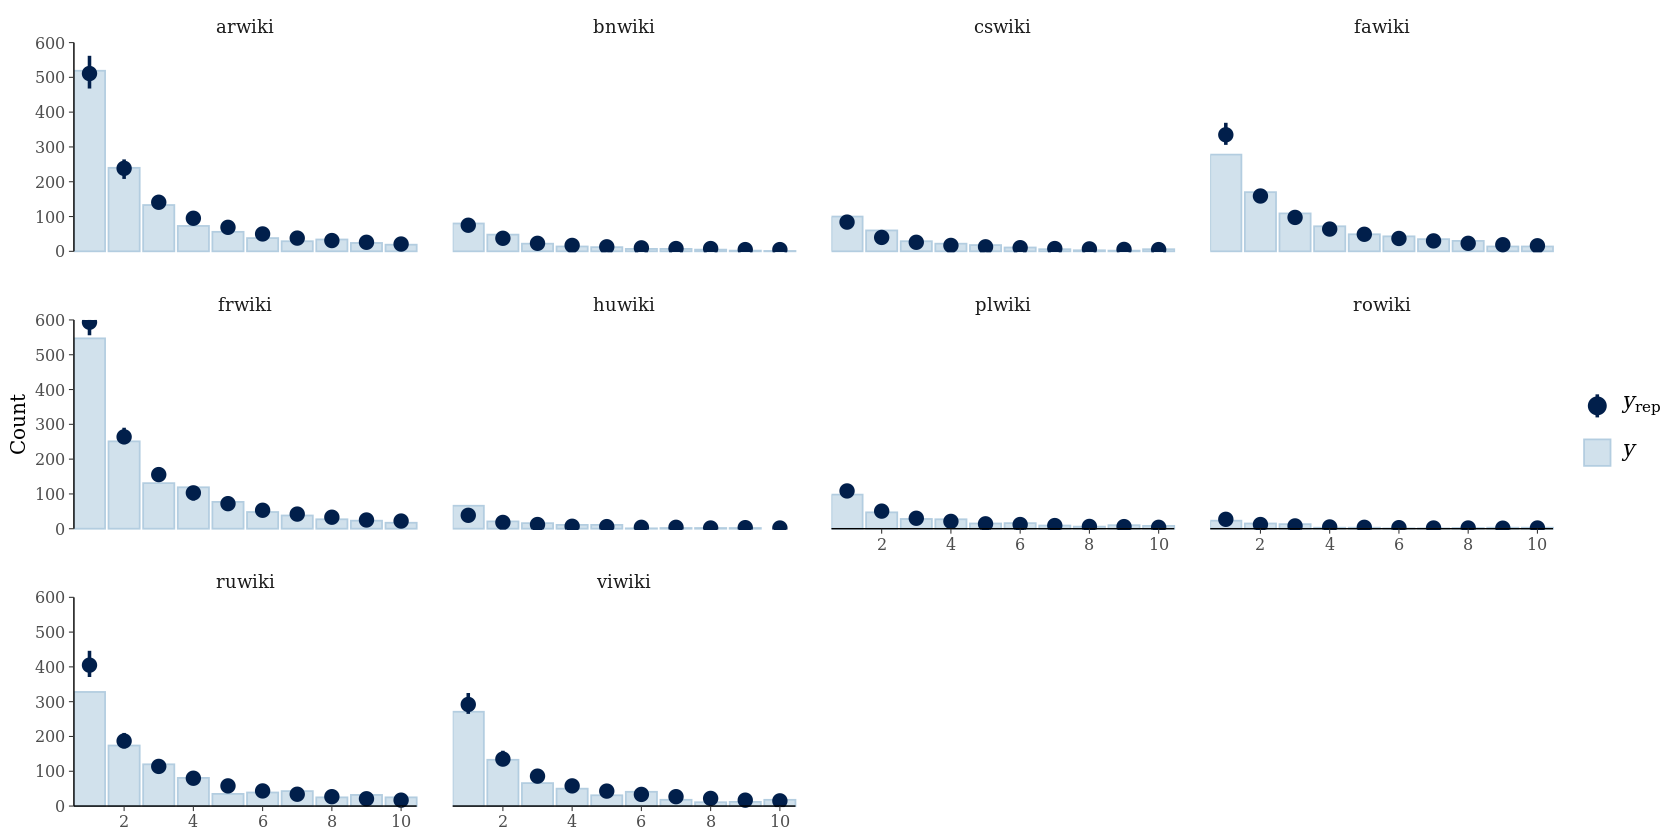

In [22]:
pp_check(constr.article.edits.2w.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 600));

Let's use the geometric mean to compare the groups this time:

In [28]:
control.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Control",]$num_const_article_edits_2w
        )
    )
) - 1
round(control.geomean, 3)

[1] 0.082

In [29]:
unstructured.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Unstructured",]$num_const_article_edits_2w
        )
    )
) - 1
round(unstructured.geomean, 3)

[1] 0.085

In [30]:
addalink.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Add-a-link",]$num_const_article_edits_2w
        )
    )
) - 1
round(addalink.geomean, 3)

[1] 0.092

In [31]:
round(unstructured.geomean - control.geomean, 3)

[1] 0.003

In [32]:
round(addalink.geomean - control.geomean, 3)

[1] 0.01

In [33]:
round(100 * (unstructured.geomean - control.geomean) / control.geomean, 1)

[1] 3.5

In [34]:
round(100 * (addalink.geomean - control.geomean) / control.geomean, 1)

[1] 12.8